# One vs One Analysis

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2
import gkpose as gk
import ast
import re

In [2]:
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]

## Import Data

In [3]:
#Import 3D keypoints - set
set_3d_df = pd.read_csv('../1v1Data/set_3d.csv', index_col=0)
set_3d_df = gk.getPhotoID(set_3d_df)

In [4]:
#Import 2D keypoints - set
set_2d_df = pd.read_csv('../1v1Data/set_2d.csv', index_col=0)
set_2d_df = gk.getPhotoID(set_2d_df)

In [5]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('../StatsBomb/1v1s.csv', index_col=0, converters = converter)

In [6]:
#Get features of each one v one. 
#Can add key pass features later
location_x = []
location_y = []
goalkeeper_x = []
goalkeeper_y = []
striker_distance_to_goal = []
shot_angle = []
gk_engage = []
gk_names = []
for i in range(len(sb_df)):
    shooter_x,shooter_y,_,_,_,_,gk_x,gk_y,is_gk = gk.getFreezeFrame(sb_df, shot_id=i)
    player_names = []
    for p in range(len(sb_df.loc[i,'shot_freeze_frame'])):
        player_names.append(sb_df.loc[i,'shot_freeze_frame'][p]['player']['name'])
    gk_names.append(np.array(player_names)[is_gk.astype(bool)][0])
    location_x.append(shooter_x)
    location_y.append(shooter_y)
    goalkeeper_x.append(gk_x[0])
    goalkeeper_y.append(gk_y[0])
    shot_dist = gk.distance_to_goal(shooter_x, shooter_y)
    striker_distance_to_goal.append(shot_dist) #shot distance to goal
    shot_angle.append(gk.goal_angle(shooter_x, shooter_y)) #shot angle
    gk_striker_dist = gk.distance_to_goal(shooter_x, shooter_y, gk_x[0], gk_y[0])
    gk_engage.append(gk_striker_dist / shot_dist) #Goalkeeper engagement metric
    
#add features to dataframe
sb_df['shooter_x'] = location_x
sb_df['shooter_y'] = location_y
sb_df['goalkeeper_x'] = goalkeeper_x
sb_df['goalkeeper_y'] = goalkeeper_y
sb_df['distance_to_goal'] = striker_distance_to_goal
sb_df['shot_angle'] = shot_angle
sb_df['gk_engage'] = gk_engage
sb_df['gk_name'] = gk_names

#Clean df
sb_df['shot_first_time'] = sb_df['shot_first_time'].fillna(False).astype(int)
sb_df['under_pressure'] = sb_df['under_pressure'].fillna(False).astype(int)
sb_df.loc[sb_df['duration'] > 20, 'duration'] = np.mean(sb_df['duration'])

#Keep only selected features
sb_df = sb_df[['duration','play_pattern_name','under_pressure','shot_outcome_name',
               'shot_first_time','distance_to_goal','shot_angle','gk_name','gk_engage']].copy()

In [7]:
sb_df.head()

,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,0.240,Regular Play,1,Saved,1,13.453624,48.012788,Danijel Subašić,0.525588
1,0.213,Regular Play,0,Saved,0,14.866069,47.726311,David Ospina Ramírez,0.190261
2,0.667,Regular Play,0,Goal,0,13.892444,30.256437,Wojciech Szczęsny,0.580334
3,0.827,From Counter,0,Goal,0,15.132746,7.594643,Wojciech Szczęsny,0.738818
4,0.453,From Corner,0,Blocked,0,8.062258,60.255119,David Ospina Ramírez,0.447214


In [8]:
set_3d_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,file,photo_id
0,-0.187500,0.281250,-0.015079,-0.140625,0.140625,0.169988,-0.046875,-0.015625,-0.012308,0.046875,...,-0.21875,-0.011179,0.203125,-0.093750,0.066936,0.281250,0.000000,0.089892,382-2.png,382
1,0.171875,0.281250,0.033766,0.187500,0.140625,0.152587,0.031250,0.000000,-0.045793,-0.031250,...,-0.21875,0.033514,0.031250,-0.093750,0.138639,0.109375,-0.031250,0.116491,262-2.png,262
2,-0.093750,0.359375,0.016994,0.015625,0.234375,0.005835,-0.031250,0.015625,-0.043475,0.046875,...,-0.15625,-0.072264,0.234375,-0.046875,-0.004875,0.281250,0.062500,-0.011386,537-2.png,537
3,-0.156250,0.390625,-0.044468,-0.140625,0.171875,0.159150,-0.046875,0.000000,-0.028738,0.062500,...,-0.34375,-0.019926,0.234375,-0.234375,0.068202,0.359375,-0.140625,0.027107,476-2.png,476
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,-0.28125,-0.014175,0.140625,-0.234375,0.037226,0.140625,-0.109375,0.019169,63.png,63


In [9]:
#Merge set_3d_df (file) with sb_df (index)
set_3d_df = set_3d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')
set_2d_df = set_2d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')

In [10]:
set_3d_df.head()

,0,1,2,3,4,5,6,7,8,9,...,photo_id,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,-0.187500,0.281250,-0.015079,-0.140625,0.140625,0.169988,-0.046875,-0.015625,-0.012308,0.046875,...,382,0.186800,From Free Kick,0,Saved,0,7.280110,74.054604,Jonas Lössl,0.566352
1,0.171875,0.281250,0.033766,0.187500,0.140625,0.152587,0.031250,0.000000,-0.045793,-0.031250,...,262,0.454694,From Throw In,1,Goal,0,11.180340,63.434949,Hugo Lloris,0.644981
2,-0.093750,0.359375,0.016994,0.015625,0.234375,0.005835,-0.031250,0.015625,-0.043475,0.046875,...,537,0.771300,From Throw In,0,Goal,0,11.313708,45.000000,Mathew Ryan,1.000000
3,-0.156250,0.390625,-0.044468,-0.140625,0.171875,0.159150,-0.046875,0.000000,-0.028738,0.062500,...,476,0.714875,Regular Play,0,Saved,0,12.041595,4.763642,Tom Heaton,0.332182
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,63,0.533000,From Free Kick,0,Goal,1,8.485281,45.000000,Eiji Kawashima,0.687184


In [11]:
sets_3d = set_3d_df.loc[:,'0':'47'].values
print(sets_3d.shape)

(590, 48)


In [12]:
sets_2d = set_2d_df.loc[:,'0':'31'].values
print(sets_2d.shape)

(590, 32)


In [13]:
np.where(set_3d_df['photo_id'] == 454)[0]

array([ 62,  90, 416])

## Camera-view Invariant Dataset

In [14]:
#Get camera-view invariant dataset of 3d poses
cvi_arr = gk.cameraInvariantDataset(sets_3d)

In [16]:
#Rotates the poses from images taken from behind by 180 degrees
sets_3d_cvi = gk.flipBehindPoses(cvi_arr)

In [18]:
np.where(set_3d_df['photo_id'] == 10)[0]

array([74])

In [23]:
#Create the cvi sets dataframe
set_3d_cvi_df = pd.DataFrame(sets_3d_cvi)
set_3d_cvi_df.columns = set_3d_cvi_df.columns.astype(str)
cols = ['file', 'photo_id', 'duration', 'play_pattern_name', 'under_pressure',
       'shot_outcome_name', 'shot_first_time', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage']
set_3d_cvi_df[cols] = set_3d_df[cols]

In [24]:
#Create cvi set array with gk_engage metric included
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi = set_3d_cvi_df.loc[:,keep_cols].values
print(sets_3d_cvi.shape)

(590, 49)


In [25]:
set_3d_cvi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,photo_id,duration,play_pattern_name,under_pressure,shot_outcome_name,shot_first_time,distance_to_goal,shot_angle,gk_name,gk_engage
0,-0.187270,0.281250,0.017709,-0.108971,0.140625,0.191825,-0.048300,-0.015625,-0.003981,0.047579,...,382,0.186800,From Free Kick,0,Saved,0,7.280110,74.054604,Jonas Lössl,0.566352
1,-0.084613,0.281250,-0.153368,-0.003635,0.140625,-0.241714,-0.055167,0.000000,0.005496,0.049572,...,262,0.454694,From Throw In,1,Goal,0,11.180340,63.434949,Hugo Lloris,0.644981
2,-0.047243,0.359375,0.082741,0.014513,0.234375,-0.008219,-0.053391,0.015625,-0.004006,0.063689,...,537,0.771300,From Throw In,0,Goal,0,11.313708,45.000000,Mathew Ryan,1.000000
3,-0.157551,0.390625,0.039614,-0.042210,0.171875,0.208141,-0.054964,0.000000,-0.001450,0.065672,...,476,0.714875,Regular Play,0,Saved,0,12.041595,4.763642,Tom Heaton,0.332182
4,-0.125000,0.406250,-0.001968,-0.125000,0.203125,0.166595,-0.062500,0.000000,-0.005656,0.078125,...,63,0.533000,From Free Kick,0,Goal,1,8.485281,45.000000,Eiji Kawashima,0.687184


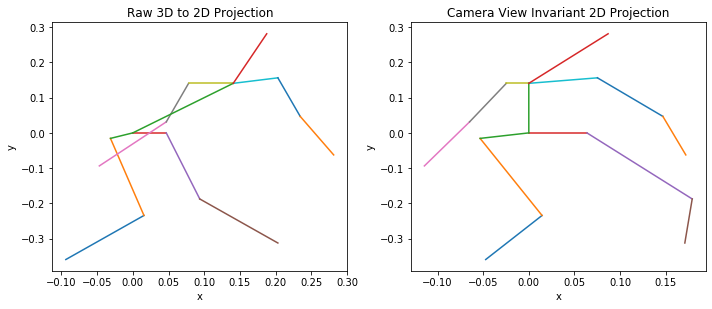

In [26]:
pose_id = 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(2, 2, 1)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_title('Raw 3D to 2D Projection')
ax = fig.add_subplot(2, 2, 2)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_title('Camera View Invariant 2D Projection')
plt.tight_layout()
plt.show()

## Remove Bad Pose Predictions

Array ID: 1
File Name: 262-2.png


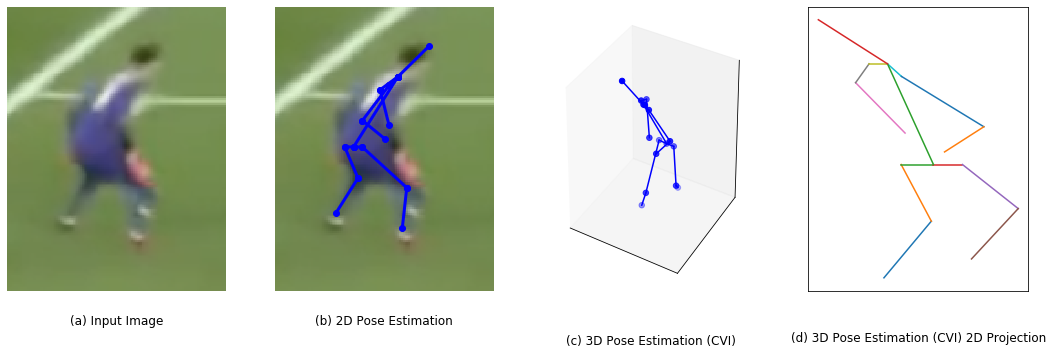

In [27]:
array_id = 1
gk.plot2D3DPose(array_id, set_3d_df, sets_2d, sets_3d_cvi, '../1v1Data/set/', mpii_edges)

In [28]:
#List of the array_ids in which to remove because they are bad prediction of true pose
#Removed based on the CVI 2D projection
to_remove_sets = np.array([1,6,7,11,14,25,27,28,31,32,37,40,42,43,44,51,52,53,55,58,
                           63,65,72,81,83,85,87,94,96,108,109,110,113,114,116,117,119,
                           123,131,133,135,136,137,140,141,143,144,147,150,151,154,156,
                           157,159,160,161,163,167,170,176,189,193,195,196,198,200,
                           202,203,206,207,210,211,213,216,217,218,220,227,228,235,
                           237,238,242,243,244,245,250,251,252,255,261,262,267,268,
                           270,271,274,275,276,282,287,291,296,297,298,304,305,311,312,
                           316,320,323,324,326,327,328,333,334,335,341,350,351,352,370,
                           372,374,379,387,388,389,390,395,397,401,406,411,413,414,418,
                           419,423,433,436,439,443,446,451,452,453,456,462,465,470,472,
                           474,475,480,489,490,494,502,507,509,515,517,522,528,532,533,
                           537,553,555,558,566,567,570,572,575,579,580,585,])
print("Removing " + str(len(to_remove_sets)) + " of " + 
      str(len(sets_3d_cvi)) + " poses, " + str(100*np.round(len(to_remove_sets)/len(sets_3d_cvi), 2)) + "%")

Removing 181 of 590 poses, 31.0%


In [29]:
#Remove selected poses
set_3d_cvi_clean_df = set_3d_cvi_df.drop(to_remove_sets).reset_index(drop=True)
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi_clean = set_3d_cvi_clean_df.loc[:,keep_cols].values
print(sets_3d_cvi_clean.shape)

(409, 49)


In [30]:
set_3d_cvi_clean_df.loc[5,'photo_id']

406

## Visualisations / Analysis

<IPython.core.display.Javascript object>


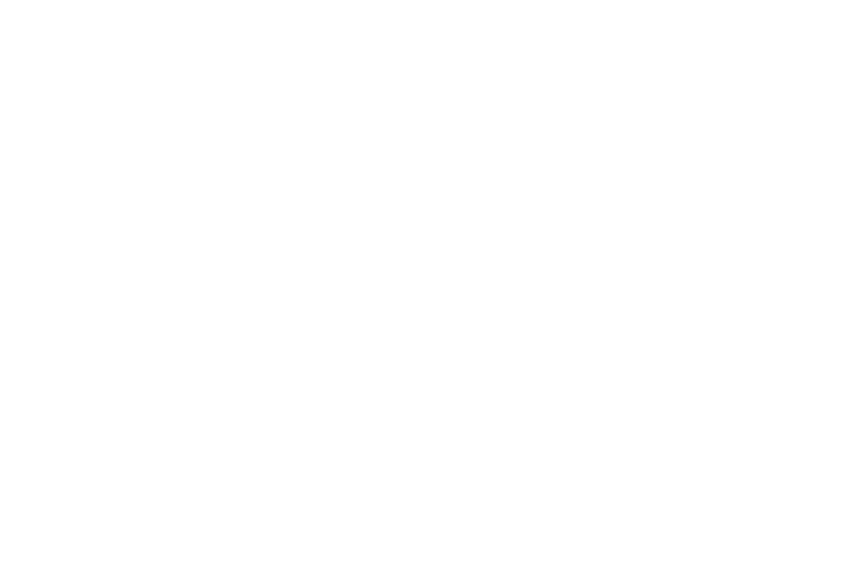

<IPython.core.display.Javascript object>


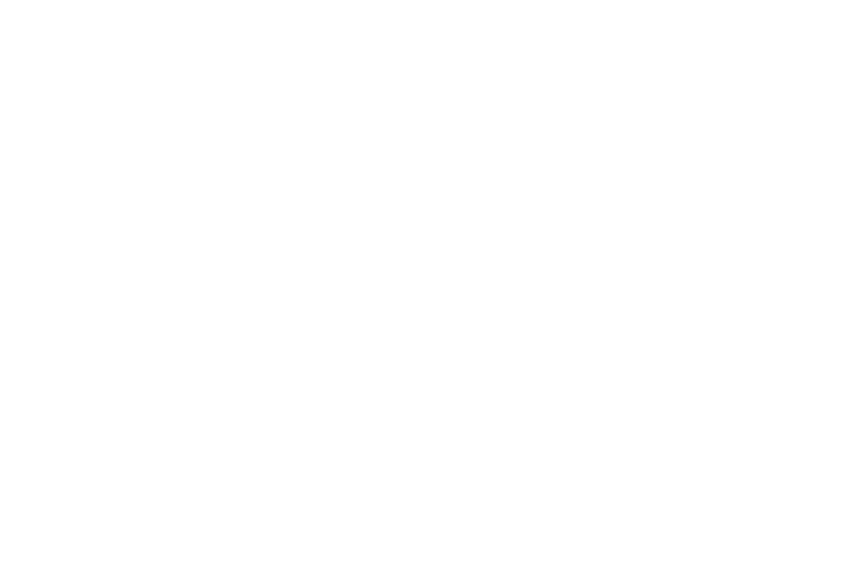

In [31]:
%matplotlib notebook
points = gk.pose_to_matrix(sets_3d[189])
fig = plt.figure()
ax = fig.add_subplot((111),projection='3d')
gk.plot3D(ax, points, edges=mpii_edges)
plt.show()

## Unsupervised Learning
Body Pose Datasets:
* sets_3d_cvi_clean : 3D Camera-view invariant, bad poses removed, gk engagement metric
* sets_2d_proj : 3D-2D projection onto x-y, CVI, bad poses removed, gk engagement metric
* sets_3d_cvi : 3D Camera-view invariant, gk engagement metric
* sets_3d : Raw 3D Body Pose
* sets_2d : Raw 2D Body Pose in image coordinates

In [33]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
sets_2d_proj = np.delete(sets_3d_cvi_clean, to_delete, 1)

In [34]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Sets: 3D - 2D Projection
* This had been giving two clear clusters - but these were just images that were from in front and from behind. Therefore we need a further cleaning step where we flip body poses where the image was taken from behind

In [35]:
sil, iner = gk.silhouetteInertia(sets_2d_proj)

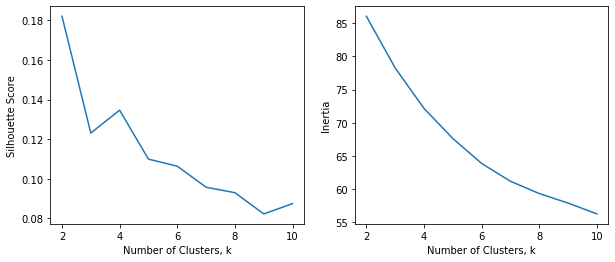

In [64]:
gk.plotSilIner(sil, iner, save='1v1s/sil_iner_2d_proj')

In [37]:
k=2
kmeans_clusters = gk.getKMeans(sets_2d_proj, k=k)
gmm_clusters = gk.getGMM(sets_2d_proj, k=k)
hier_clusters = gk.getHier(sets_2d_proj, k=k)

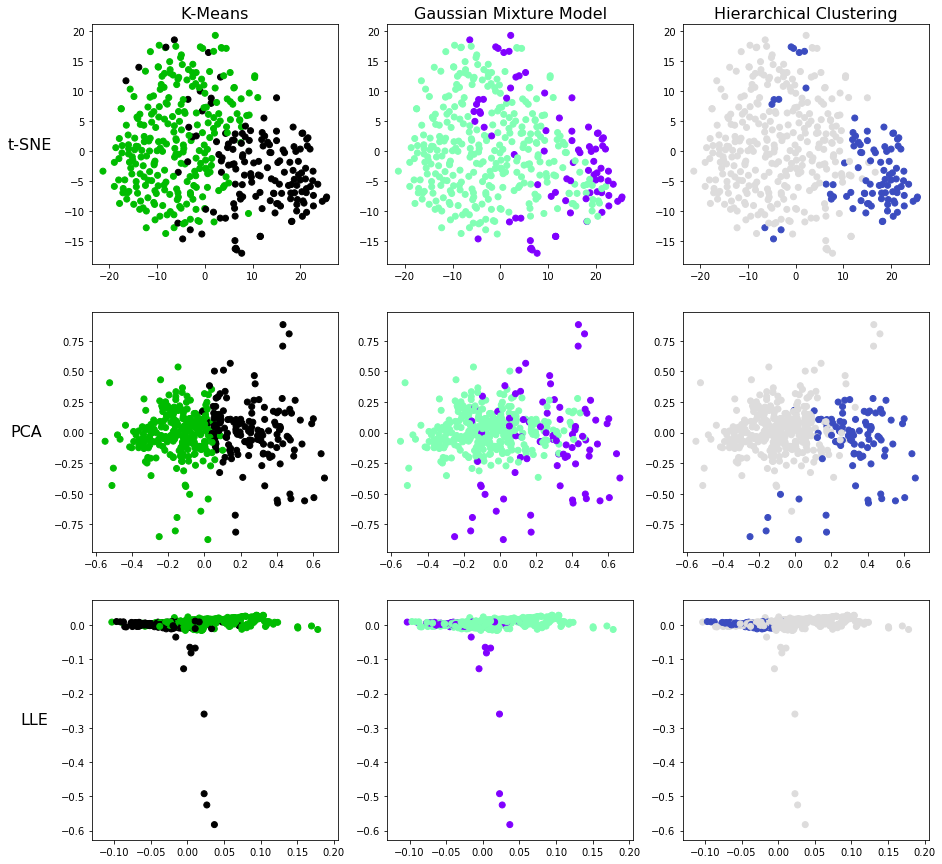

In [52]:
gk.plotManifold(sets_2d_proj, kmeans_clusters, gmm_clusters,
             hier_clusters, k=k, save='1v1s/2d_proj_clusters')

In [56]:
def ImageID(df, array_id):
    #Get photo id's of poses
    return df.loc[array_id, 'file']

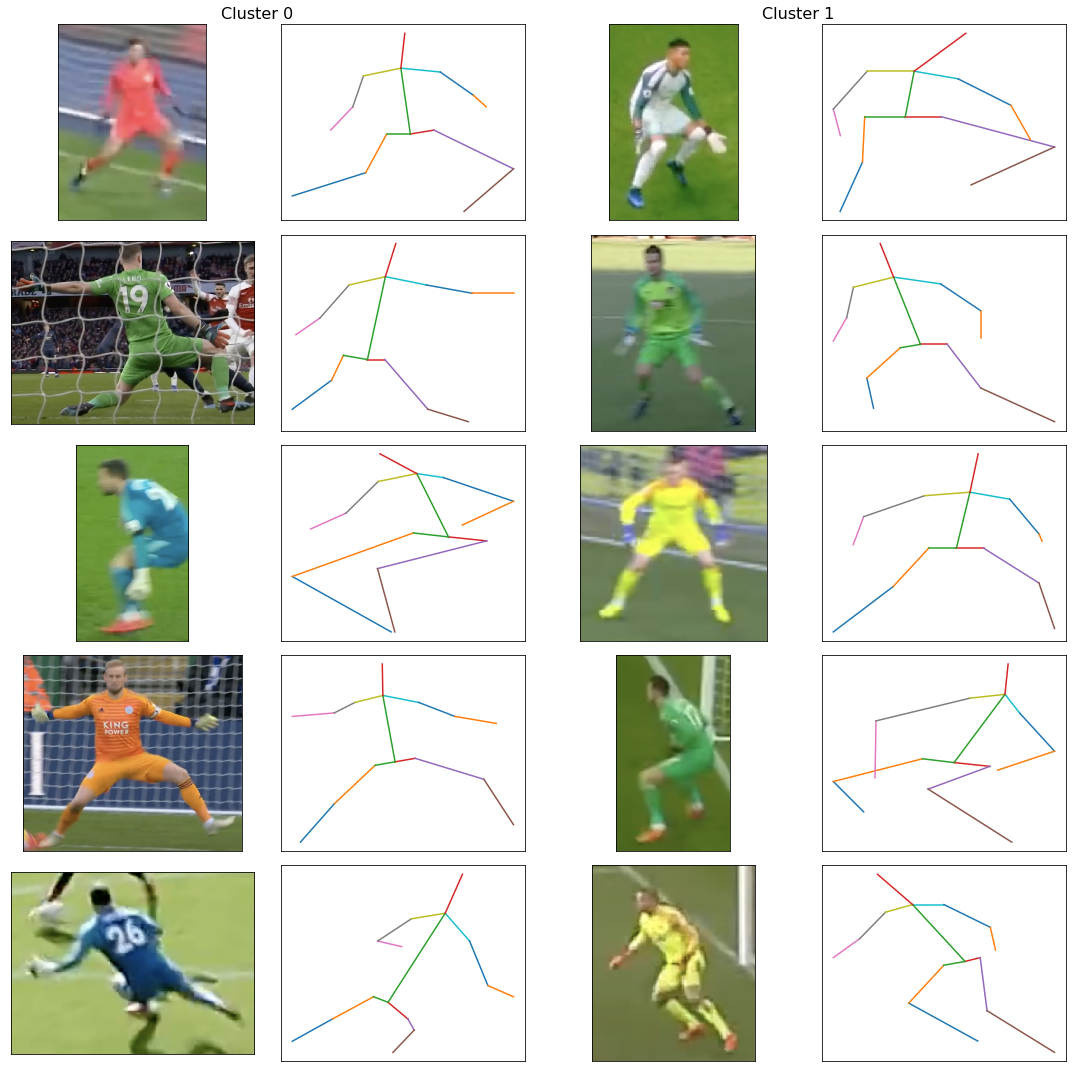

In [55]:
#KMeans - 3D pose, 2D pose viz cluster examples
#Use for 2 clusters on 3D data
path = '../1v1Data/set/'
ax_array = [1, 5, 9, 13, 17]
fig = plt.figure(figsize=(15, 15))
for a in ax_array:
    arr_id = np.random.choice(np.where(kmeans_clusters == 0)[0])
    photo_id = ImageID(set_3d_cvi_clean_df, arr_id)
    ax = fig.add_subplot(5, 4, a)
    ax.imshow(gk.importImage(path + photo_id))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+1)
    gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi_clean[arr_id][:-1]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(0), position=(-0.1, 1), size=16)
        
    arr_id = np.random.choice(np.where(kmeans_clusters == 1)[0])
    photo_id = ImageID(set_3d_cvi_clean_df, arr_id)
    ax = fig.add_subplot(5, 4, a+2)
    ax.imshow(gk.importImage(path + photo_id))
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(5, 4, a+3)
    gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi_clean[arr_id][:-1]), mpii_edges)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if a == 1:
        ax.set_title('Cluster ' + str(1), position=(-0.1, 1), size=16)
    
plt.tight_layout()
#plt.savefig('viz/1v1s/2d_proj_clusters_examples.png', dpi=500)
plt.show()

In [58]:
np.array(ImageID(set_3d_cvi_clean_df, np.where(kmeans_clusters == 0)[0]))

array(['476-2.png', '360.png', '437-3.png', '75.png', '185-3.png',
       '508-2.png', '367.png', '185-2.png', '175.png', '65.png',
       '388.png', '413.png', '323-2.png', '102-2.png', '454-3.png',
       '295.png', '360-2.png', '213.png', '10.png', '204-2.png',
       '494-2.png', '139-2.png', '494-3.png', '139-3.png', '198-2.png',
       '454-2.png', '384-2.png', '305-2.png', '14.png', '428-2.png',
       '172.png', '413-2.png', '73.png', '325.png', '362-3.png',
       '239.png', '390-5.png', '490-5.png', '198.png', '384-3.png',
       '102.png', '453-2.png', '470.png', '316.png', '114.png', '29.png',
       '289.png', '144-2.png', '505.png', '317.png', '459.png', '416.png',
       '503.png', '477.png', '463.png', '416-3.png', '477-2.png',
       '477-3.png', '455-3.png', '455-2.png', '385-2.png', '121-2.png',
       '39.png', '345-2.png', '310.png', '280.png', '438-2.png',
       '235-2.png', '459-3.png', '421-3.png', '440-2.png', '390-2.png',
       '461.png', '239-2.png', '409-2

In [65]:
#Difference in mean gk engagement metric between 2 clusters
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters == 0, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters == 1, 'gk_engage']))

0.38816964013752436
0.7406665208648272


# Pose Matching - kNN
* Build a smaller, labelled dataset, and train a kNN on it.
* To predict the type of save of one of the PL/WC saves, predict using the trained kNN.